In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os

data_dir = '/content/drive/My Drive/anamoly_detection/carpet'
if os.path.exists(data_dir):
    print("Path exists!")
else:
    print("Path does not exist. Check your directory path.")


Mounted at /content/drive
Path exists!


In [4]:
from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0
])

In [5]:
from PIL import Image
image_path = '/content/drive/My Drive/anamoly_detection/carpet/test/hole/000.png'
image = Image.open(image_path)
print(image.size)

(1024, 1024)


In [6]:
image = transform(image)
print(image.shape)

torch.Size([3, 224, 224])


In [7]:
from torchvision.datasets import ImageFolder

train_image_path = '/content/drive/My Drive/anamoly_detection/carpet/train'
good_dataset = ImageFolder(root=train_image_path, transform=transform)
x, y = good_dataset[0]
print("Image Shape:", x.shape)
print("Label:", y)


Image Shape: torch.Size([3, 224, 224])
Label: 0


In [8]:
import torch

train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])
print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))


Total number of samples in the original dataset: 280
Number of samples in the training subset: 224
Number of samples in the testing subset: 56


In [9]:
import torch
from torch.utils.data import DataLoader

BS = 16

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

image_batch, label_batch = next(iter(train_loader))
print("Image batch shape:", image_batch.shape)
print("Label batch shape:", label_batch.shape)


Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder() # Run on CPU instead
input_image = torch.randn(1, 3, 233, 233)  # Sample input image
output_image = model(input_image)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#traning
from tqdm import tqdm
Loss = []
Validation_Loss = []


num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    for img, _ in train_loader:
        img = img.to(device)

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients.
    Loss.append(loss.item())
 # Validation loop (with individual images)
     # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.to(device)
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 2 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))



 10%|█         | 1/10 [07:50<1:10:30, 470.06s/it]

Epoch [1/10], Loss: 0.0152, Validation Loss: 0.0157


 30%|███       | 3/10 [23:31<54:51, 470.17s/it]  

Epoch [3/10], Loss: 0.0130, Validation Loss: 0.0131


 50%|█████     | 5/10 [39:19<39:22, 472.52s/it]

Epoch [5/10], Loss: 0.0128, Validation Loss: 0.0128


 70%|███████   | 7/10 [54:56<23:31, 470.41s/it]

Epoch [7/10], Loss: 0.0128, Validation Loss: 0.0125


 90%|█████████ | 9/10 [1:10:34<07:49, 469.65s/it]

Epoch [9/10], Loss: 0.0124, Validation Loss: 0.0120


100%|██████████| 10/10 [1:18:20<00:00, 470.05s/it]


In [15]:
# Save the model
torch.save(model.state_dict(), 'carpet_autoencoder.pth')
model.eval()

ckpoints = torch.load("carpet_autoencoder.pth")
model.load_state_dict(ckpoints)
#model_save_path = f"{category}_autoencoder.pth

<ipython-input-15-f7fc0395c992>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpoints = torch.load("carpet_autoencoder.pth")


<All keys matched successfully>

In [16]:
import numpy as np


In [17]:
RECON_ERROR=[]
with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(device)
        recon = model(data)
        data_recon_squared_mean =  ((data-recon)**2).mean(axis=(1))[:,0:-10,0:-10].mean(axis=(1,2))

        RECON_ERROR.append(data_recon_squared_mean)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()


In [18]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

In [19]:
from pathlib import Path
y_true=[]
y_pred=[]
y_score=[]

model.eval()

with torch.no_grad():

    test_path = Path('/content/drive/My Drive/anamoly_detection/carpet/test')

    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        # if fault_type != 'good':
        test_image = transform(Image.open(path)).to(device).unsqueeze(0)
        recon_image = model(test_image)

        # y_score_image =
        y_score_image =  ((test_image - recon_image)**2).mean(axis=(1))[:,0:-10,0:-10].mean()

        y_pred_image = 1*(y_score_image >= best_threshold)

        y_true_image = 0 if fault_type == 'good' else 1

        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

AUC-ROC Score: 0.3358747993579454


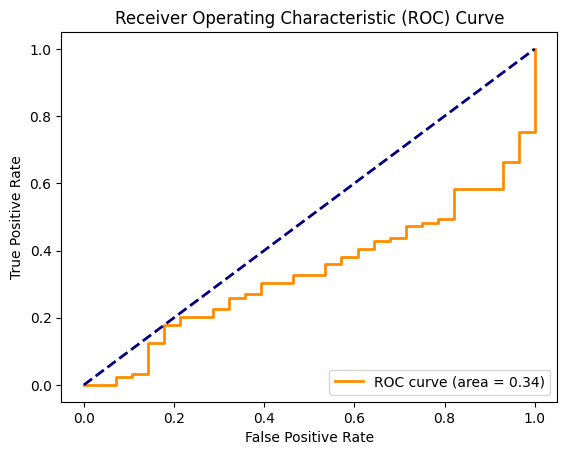

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

